# 시작

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
from IPython.display import display
import IPython
import numpy as np
import os,sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
!pip install mglearn
!pip install gensim
!pip install nltk
import nltk
import mglearn as mglearn
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import re
import urllib.request
!pip install konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install torchtext --upgrade
#https://github.com/pytorch/text/releases
import torchtext
torch.manual_seed(1)

from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)
os.chdir("/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/")
print(f"현재 경로 : {os.getcwd()}")


Mounted at /gdrive/
     |████████████████████████████████| 542kB 7.2MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=69782908d0b0ee817b067f5acdda9c9087b3b3bcad67f7d3082570aad33c0b3e
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn
     |████████████████████████████████| 19.4MB 7.4MB/s 
     |████████████████████████████████| 92kB 3.0MB/s 
     |████████████████████████████████| 460kB 55.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Requirement already up-to-date: torchtext in /usr/local/lib/python3.7/dist-packages (0.9.0)
다음 기기로 학습합니다: cuda
현재 경로 : /gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification


# 서브 함수들

In [ ]:
import json
from collections import OrderedDict
def ModelPath(model_name):
  Basic = "/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/Models/"
  return Basic+model_name+'.pt'

def JsonPath(model_name):
  Basic = "/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/Models/" 
  return Basic+model_name+'.json'

def Directory():
  while True:
    try:
      directory=f"/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/Models/"
      if not os.path.exists(directory):
            os.makedirs(directory)
            os.chdir(directory)
            return directory
            break
      else:
        os.chdir(directory)
        return directory
        break
    except OSError:
      print ('Error: Creating directory. ' +  directory)
      continue

def SaveModels(model_name):
  import json
  from collections import OrderedDict
  PATH = Directory()+model_name
  
  torch.save({
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
             }, PATH)
  print(f'Saved Path :{PATH}')

def LoadModels(PATH,model,optimizer):
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.train()
  return model,optimizer

def SaveJson(json_name,valid_loss,valid_acc):
  import json
  from collections import OrderedDict
  PATH = json_name
  model_info = OrderedDict()
  model_info['name'] = model_name
  model_info['path'] = PATH
  model_info['Best Loss'] = str(min(valid_loss))
  model_info['Best Acc'] = str(max(valid_acc).item())

  with open(PATH,'w',encoding='utf-8') as make_file:
    json.dump(model_info, make_file, ensure_ascii=False, indent='\t')
  print('Saving JSON completed!')

def LoadJson(PATH):
  with open(PATH,'r') as f:
    model_info = json.load(f)
  #print(json.dumps(model_info))

  return model_info

def today():
  from datetime import datetime
  year = str(datetime.today().year)

  if datetime.today().month<10:
    month = str(0)+ str(datetime.today().month)
  else : month = str(datetime.today().month)

  if datetime.today().day<10:
    day = str(0)+ str(datetime.today().day)
  else : day = str(datetime.today().day)

  if (datetime.today().hour + 9)%24 < 10:
    hour = str(0)+ str((datetime.today().hour+9)%24)
  else : hour = str((datetime.today().hour+9)%24)

  if datetime.today().minute<10:
    min = str(0)+ str(datetime.today().minute)
  else : min = str(datetime.today().minute)


  return int(year+month+day)

def JsonCheck():
  PATH="/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/Models/"
  file_list=os.listdir(PATH)
  json_list=[file for file in file_list if '.json' in file]
  columns=['name', 'path', 'Best Loss', 'Best Acc']
  check={}
  for column in columns:
    check[column]=[]
  
  for JSON in json_list:
    info=LoadJson(PATH+JSON)
    for key in columns:
      if key in ['Best Loss', 'Best Acc']:
        info[key]=round(float(info[key]),4)
      check[key].append(info[key])
  check_df=pd.DataFrame(check)
  check_df=check_df[['name','Best Loss']]
  check_df=check_df.sort_values(by='Best Loss')
  return check_df


# 데이터 불러오기 read_csv

In [ ]:
train=pd.read_csv('/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/train.csv',header=0,encoding='utf-8',verbose=True)
test = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/test_x.csv',header=0,encoding='utf-8',verbose=True)
train['author'].value_counts(sort=False).plot(kind='bar')
print(train.groupby('author').size().reset_index(name = 'count'))
maxcount=max(train.groupby('author').size())
class_weight=[round(maxcount/count,3) for count in train.groupby('author').size()]
class_weight

Tokenization took: 277.31 ms
Type conversion took: 89.85 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 113.15 ms
Type conversion took: 51.65 ms
Parser memory cleanup took: 0.01 ms


# EDA
[텍스트 분류 문제]
1. 데이터 크기
2. 데이터의 개수
3. 각 리뷰의 문자 길이 분포
4. 많이 사용된 단어
5. 긍정, 부정 데이터의 분포
6. 각 리뷰의 단어 개수 분포 : 띄어쓰기 기준
7. 특수문자 및 대문자, 소문자, 숫자 비율

## 클래스 분포 확인

   author  count
0       0  13235
1       1   7222
2       2  11554
3       3  15063
4       4   7805


[1.138, 2.086, 1.304, 1.0, 1.93]

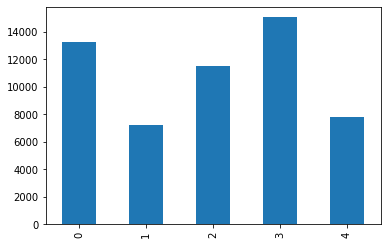

In [ ]:
train['author'].value_counts(sort=False).plot(kind='bar')
print(train.groupby('author').size().reset_index(name = 'count'))
maxcount=max(train.groupby('author').size())
class_weight=[round(maxcount/count,3) for count in train.groupby('author').size()]
class_weight

## 공백 없음

In [ ]:
null_check=train.isnull().values.any()
print(null_check)
if null_check:
  print(train.isnull().sum())
  print(train.loc[train.text.isnull()])

False


# 데이터셋 구성

In [ ]:
nltk.download('punkt')
!pip install sacremoses
!pip install revtok
import revtok
import sacremoses
import nltk.tokenize
from torchtext.data.utils import get_tokenizer
from torchtext import data
from nltk.corpus import stopwords  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 890kB 10.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=23bcd561ed91ce734a5a3546f77784bcebc0b764b0514f0a49b233a32d6874f3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 전처리 함수 설정

## 1) Cleaning

In [ ]:
def cleaning(sentences):
  cleaned_text = []
  for words in sentences:
    words = re.sub('[^0-9A-Za-z"]',' ', words).lower()
    words = re.sub(r' +', ' ', words)
    words = re.sub(r'\n', ' ', words)
    words = " ".join(words.split())
    cleaned_text.append(words)
  return cleaned_text

## 2) Tokenizer

### (1) spacy

In [ ]:
tokenizer = get_tokenizer("spacy")
#tokenizer = get_tokenizer('toktok')
nltk.download('stopwords')
Stopwords=stopwords.words('english')
Stopwords.extend(['','the','a','an','"'])

#초기세팅 
Text = torchtext.data.Field(preprocessing = cleaning, tokenize=tokenizer,batch_first=True,stop_words=Stopwords)#,fix_length=max_sequence_length)
Label = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
Index = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None) 
fields = [('index',Index),('text', Text),('author', Label)]

dataset = torchtext.data.TabularDataset(
  path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/train.csv', format='csv',
  fields=fields,
  skip_header=True
)
from torchtext.data import Iterator
batch_size=256

train_loader = Iterator(dataset=trainset, batch_size = batch_size)
valid_loader = Iterator(dataset=validset, batch_size = batch_size)
test_loader = Iterator(dataset=testset, batch_size = batch_size)
data_loader={'train':train_loader,'valid':valid_loader,'test':test_loader}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: ignored

평균 : 31
중앙값 : 19.0
최소값 : 2
최대값 : 296
20% 수 : 10.0
30% 수 : 13.0
40% 수 : 16.0
50% 수 : 19.0
60% 수 : 23.0
70% 수 : 31.0
80% 수 : 46.0
90% 수 : 76.0
100% 수 : 296.0
95% 수 : 106.0
99% 수 : 163.0



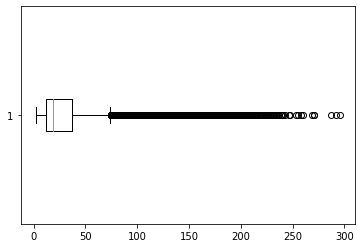

In [ ]:
seq_length=[]
for i in range(len(dataset)):
  seq_length.append(len(vars(dataset[i])['text']))

print(f"평균 : {int(np.mean(seq_length))}")
print(f"중앙값 : {np.median(seq_length)}")
print(f'최소값 : {np.min(seq_length)}')
print(f'최대값 : {np.max(seq_length)}')
for i,q in enumerate(range(20,110,10)): 
  print(f'{q}% 수 : {np.percentile(seq_length,q)}')
print(f'95% 수 : {np.percentile(seq_length,95)}')
print(f'99% 수 : {np.percentile(seq_length,99)}')
print()
plt.boxplot(seq_length,vert=False)
plt.show()
#pd.Series(seq_length).plot(kind='line')

Fields 재 설정 후 데이터 셋 구성 : max_sequence_length = 106

In [ ]:
max_sequence_length = 106
Text = torchtext.data.Field(preprocessing = cleaning, tokenize=tokenizer,batch_first=True,stop_words=Stopwords,fix_length=max_sequence_length)
Label = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
Index = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None) 
fields = [('index',Index),('text', Text),('author', Label)]
test_fields=[('index',Index),('text', Text)]

dataset = torchtext.data.TabularDataset(
  path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/train.csv', format='csv',
  fields=fields,
  skip_header=True
)

testset = torchtext.data.TabularDataset(
  path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/test_x.csv', format='csv',
  fields=test_fields,
  skip_header=True
)

Text.build_vocab(dataset,max_size=10000,min_freq=3) 
vocab = Text.vocab
vocab.freqs
vocab_size=len(vocab)


In [ ]:
import random
trainset,validset=dataset.split(split_ratio=0.7,strata_field='label',random_state=random.seed(3))

### (2) toktok

In [ ]:
tokenizer = get_tokenizer('toktok')
nltk.download('stopwords')
Stopwords=stopwords.words('english')
Stopwords.extend(['','the','a','an','"'])

#초기세팅 
Text = torchtext.data.Field(preprocessing = cleaning, tokenize=tokenizer,batch_first=True,stop_words=Stopwords)#,fix_length=max_sequence_length)
Label = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
Index = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None) 
fields = [('index',Index),('text', Text),('author', Label)]

dataset = torchtext.data.TabularDataset(
  path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/train.csv', format='csv',
  fields=fields,
  skip_header=True
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


평균 : 31
중앙값 : 19.0
최소값 : 2
최대값 : 296
20% 수 : 10.0
30% 수 : 13.0
40% 수 : 16.0
50% 수 : 19.0
60% 수 : 23.0
70% 수 : 31.0
80% 수 : 46.0
90% 수 : 76.0
100% 수 : 296.0
95% 수 : 106.0
99% 수 : 163.0



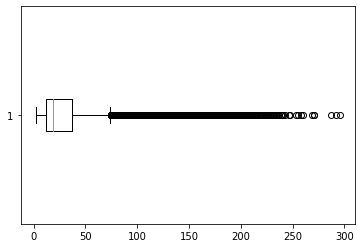

In [ ]:
seq_length=[]
for i in range(len(dataset)):
  seq_length.append(len(vars(dataset[i])['text']))

print(f"평균 : {int(np.mean(seq_length))}")
print(f"중앙값 : {np.median(seq_length)}")
print(f'최소값 : {np.min(seq_length)}')
print(f'최대값 : {np.max(seq_length)}')
for i,q in enumerate(range(20,110,10)): 
  print(f'{q}% 수 : {np.percentile(seq_length,q)}')
print(f'95% 수 : {np.percentile(seq_length,95)}')
print(f'99% 수 : {np.percentile(seq_length,99)}')
print()
plt.boxplot(seq_length,vert=False)
plt.show()
#pd.Series(seq_length).plot(kind='line')

In [ ]:
max_sequence_length = 106
Text = torchtext.data.Field(preprocessing = cleaning, tokenize=tokenizer,batch_first=True,stop_words=Stopwords,fix_length=max_sequence_length)
Label = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
Index = torchtext.data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None) 
fields = [('index',Index),('text', Text),('author', Label)]
test_fields=[('index',Index),('text', Text)]

dataset = torchtext.data.TabularDataset(
  path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/train.csv', format='csv',
  fields=fields,
  skip_header=True
)

testset = torchtext.data.TabularDataset(
  path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/test_x.csv', format='csv',
  fields=test_fields,
  skip_header=True
)

In [ ]:
import random
trainset,validset=dataset.split(split_ratio=0.7,strata_field='label',random_state=random.seed(3))

## 3) 단어임베딩 : From Scratch

In [ ]:
Text.build_vocab(dataset,min_freq=5) 
vocab = Text.vocab
vocab.freqs
vocab_size=len(vocab)
print('단어 집합의 크기 : {}'.format(len(Text.vocab)))
list(Text.vocab.stoi.items())[:22],len(Text.vocab)
#Text.vocab.itos[-20:],len(Text.vocab)
#print(list(vocab.freqs.items())[:20])

단어 집합의 크기 : 14434


([('<unk>', 0),
  ('<pad>', 1),
  ('', 2),
  ('i', 3),
  ('odin', 4),
  ('s', 5),
  ('said', 6),
  ('one', 7),
  ('the', 8),
  ('would', 9),
  ('he', 10),
  ('mr', 11),
  ('could', 12),
  ('n t', 13),
  ('it', 14),
  ('man', 15),
  ('you', 16),
  ('upon', 17),
  ('but', 18),
  ('and', 19),
  ('know', 20),
  ('well', 21)],
 14434)

평균 : 47
중앙값 : 3.0
최소값 : 1
최대값 : 500512
1 분위 수 : 1.0
2 분위 수 : 3.0
3 분위 수 : 10.0



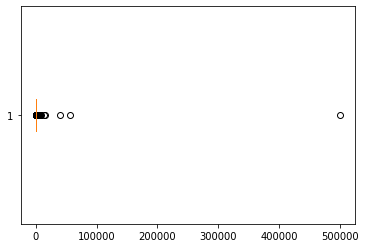

In [ ]:
#단어 등장횟수 분석
#여기에 임베딩을 활용할 수 있음

frequencies =list(vocab.freqs.values())
frequencies
print(f"평균 : {int(np.mean(frequencies))}")
print(f"중앙값 : {np.median(frequencies)}")
print(f'최소값 : {np.min(frequencies)}')
print(f'최대값 : {np.max(frequencies)}')
for i,q in enumerate(range(25,100,25)): 
  print(f'{i+1} 분위 수 : {np.percentile(frequencies,q)}')
print()
plt.boxplot(frequencies,vert=False)
plt.show()
#pd.Series(seq_length).plot(kind='line')

In [ ]:
#여기에 임베딩을 활용할 수 있음
Text.build_vocab(dataset,max_size=10000,min_freq=3) 

vocab = Text.vocab
vocab.freqs
vocab_size=len(vocab)
print('단어 집합의 크기 : {}'.format(len(Text.vocab)))
#list(Text.vocab.stoi.items())[:22],len(Text.vocab)
Text.vocab.itos[-20:],len(Text.vocab)

단어 집합의 크기 : 10002


(['lightness',
  'limped',
  'lobster',
  'loch',
  'locket',
  'loosed',
  'loyalty',
  'lucases',
  'ludwigovna',
  'lumbering',
  'magnitude',
  'mahogany',
  'malevolent',
  'maliciously',
  'managing',
  'mangled',
  'manhood',
  'manse',
  'marriages',
  'martyrdom'],
 10002)

# 데이터 로더

In [ ]:
from torchtext.data import Iterator
batch_size=256

train_loader = Iterator(dataset=trainset, batch_size = batch_size)
valid_loader = Iterator(dataset=validset, batch_size = batch_size)
test_loader = Iterator(dataset=testset, batch_size = batch_size)
data_loader={'train':train_loader,'valid':valid_loader,'test':test_loader}

In [ ]:
print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_loader)))
print('검증용 데이터의 미니 배치 수 : {}'.format(len(valid_loader)))

훈련 데이터의 미니 배치 수 : 151
검증용 데이터의 미니 배치 수 : 65


# 토크나이저에 따른 통합함수

In [ ]:
nltk.download('punkt')
!pip install sacremoses
!pip install revtok
import revtok
import sacremoses
import nltk.tokenize
import random
from torchtext.data.utils import get_tokenizer
from torchtext import data
from nltk.corpus import stopwords  
from torchtext.legacy.data import Field,TabularDataset,Iterator
def cleaning(sentences):
  cleaned_text = []
  for words in sentences:
    words = re.sub('[^0-9A-Za-z"]',' ', words).lower()
    words = re.sub(r' +', ' ', words)
    words = re.sub(r'\n', ' ', words)
    words = " ".join(words.split())
    cleaned_text.append(words)
  return cleaned_text
  
def MAX_SEQ_LEN(tok,n):
  #초기세팅
  tokenizer = get_tokenizer(tok)
  nltk.download('stopwords')
  Stopwords=stopwords.words('english')
  Stopwords.extend(['','the','a','an','"']) 
  
  Text = Field(preprocessing = cleaning, tokenize=tokenizer,batch_first=True,stop_words=Stopwords)#,fix_length=max_sequence_length)
  Label = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
  Index = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None) 
  fields = [('index',Index),('text', Text),('author', Label)]

  dataset = TabularDataset(path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/train.csv', format='csv',fields=fields,
                                          skip_header=True)
  seq_length=[]
  for i in range(len(dataset)):
    seq_length.append(len(vars(dataset[i])['text']))
  return int(np.percentile(seq_length,n))

def make_dataset_by_tokenizer(tok,n):
  tokenizer = get_tokenizer(tok)
  nltk.download('stopwords')
  Stopwords=stopwords.words('english')
  Stopwords.extend(['','the','a','an','"'])
  max_sequence_length = MAX_SEQ_LEN(tok,n)
  Text = Field(preprocessing = cleaning, tokenize=tokenizer,batch_first=True,stop_words=Stopwords,fix_length=max_sequence_length)
  Label = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
  Index = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None) 
  fields = [('index',Index),('text', Text),('author', Label)]
  test_fields=[('index',Index),('text', Text)]

  dataset = TabularDataset(
    path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/train.csv', format='csv',
    fields=fields,
    skip_header=True
  )

  testset = TabularDataset(
    path='/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/test_x.csv', format='csv',
    fields=test_fields,
    skip_header=True
  )
  Text.build_vocab(dataset,min_freq=2) 

  vocab = Text.vocab
  vocab.freqs
  vocab_size=len(vocab)
  

  trainset,validset=dataset.split(split_ratio=0.8,strata_field='label',random_state=random.seed(3))

  batch_size=256

  train_loader = Iterator(dataset=trainset, batch_size = batch_size)
  valid_loader = Iterator(dataset=validset, batch_size = batch_size)
  test_loader = Iterator(dataset=testset, batch_size = batch_size,shuffle=False)
  data_loader={'train':train_loader,'valid':valid_loader,'test':test_loader}
  return data_loader,max_sequence_length,vocab_size

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 890kB 7.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=81b048b860e225b963058e93672e9fdd810ce17808bcbbd27e17c69681a70fd8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 학습함수

In [ ]:
from torch.optim import lr_scheduler
import copy
import time
import torchvision.models as models
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=1):
    since = time.time()
    max_grad_norm=5.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 100
    train_acc=[]
    valid_acc=[]
    train_loss=[]
    valid_loss=[]
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validationidation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
                
            else:
                model.eval()   # Set model to evalidationuate mode

            running_loss = 0.0
            running_corrects = 0
            i=0
            # Iterate over data.
            for batch in data_loader[phase]:
                text = batch.text.to(device)
                batch.author=batch.author.to(device,dtype=torch.long)
                #print(batch.label.shape)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    predictions = model(text).to(device)             
                    #print(predictions.shape)
                    
                    try :
                      if model.lstm.num_layers >=1:
                       #predictions = predictions.view(len(text),-1)#[:,-1]
                       predictions = predictions.to(device)
                                          
                    except:
                      predictions = predictions.to(device)
                      #print(predictions.shape)
                    
                    preds=torch.argmax(predictions,dim=-1)
                    #print(preds)
             
                    loss = criterion(predictions, batch.author)
                    
                    #print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics(output.argmax(1) == cls)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == batch.author)/batch.author.size(0)
            
            
            epoch_loss = running_loss / len(data_loader[phase])
            epoch_acc = running_corrects / len(data_loader[phase])
            
            if phase =='train':
              
              train_acc.append(epoch_acc)
              train_loss.append(epoch_loss)
            
            if phase == 'valid':
              if scheduler:
                scheduler.step(epoch_loss)
              valid_acc.append(epoch_acc)
              valid_loss.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.5f} Acc: {epoch_acc:.5f}')
            
            if phase=='valid':
              print(f'''last learning rate:{scheduler.state_dict()['_last_lr']}''')
            
            

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'valid' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}\nBest validation Loss : {:4f}'.format(best_acc,best_loss))
 
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc,valid_acc,train_loss,valid_loss,time_elapsed

# 테스트셋 결과내기

In [ ]:
def TEST(model_ft,optimizer_ft,model_name):
  INDEX_LIST=[]
  PREDICTION_LIST=[]
  model_ft.eval()
  for batch in data_loader['test']:
    text = batch.text.to(device)
    index = batch.index.to(device) 
    predictions = model_ft(text).to(device)
    
    for i,preds in zip(index,predictions):
      temp=torch.zeros_like(preds)
      #print(torch.argmax(preds).item())
      temp[torch.argmax(preds).item()]=1
      temp = map(int,temp.to(device='cpu').numpy())
      
      PREDICTION_LIST.append(temp),INDEX_LIST.append(i.item())
  submission = pd.DataFrame(PREDICTION_LIST,index=INDEX_LIST)
  submission.to_csv(f'/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/Submissions/{model_name[:-2]}csv',index_label='index',header=True,encoding='utf-8')
  return submission

# Models

## 1) DoubleBiLSTM

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleBiLSTM(nn.Module):

    def __init__(self, vocab_size, input_size, hidden_size, batch_size, num_classes,drop_out,option,num_layer=2, batch_first=True):
        super(DoubleBiLSTM, self).__init__()
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.input_size = input_size #embedding size
        self.num_class = num_classes
        self.num_layer = num_layer
        self.option = option
        self.embedding_layer = nn.Embedding(num_embeddings=self.vocab_size, # 워드 임베딩
                                            embedding_dim=self.input_size)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,
                            num_layers = self.num_layer,
                            bidirectional = True,
                            bias=True,
                            batch_first = True
                            ,dropout=drop_out
                            )
        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(self.hidden_size,self.num_class)
        self.relu = nn.ReLU()
        #self.activation = nn.LogSoftmax(dim=-1)
        

    def forward(self, x):
        output = self.embedding_layer(x)
        #print(output.shape)
        #output = batch,embedding_size
        total, (hidden_last, cell) = self.lstm(output)
        #total =batch, seq, num_layers * num_directions
        # hidden.shape=(num_layers * num_directions, batch, hidden_size)
        #print(hidden_last.shape)
        hidden_last = hidden_last.view(self.num_layer,2,hidden_last.shape[1],self.hidden_size)
        hidden_last = hidden_last[-1,:,:,:]
        
        if self.option == 'sum':
          out = hidden_last.sum(dim=0)

        if self.option=='mean':
          out = hidden_last.mean(dim=0)
          
        out = self.linear(out)
        out = self.relu(out)
        #out = self.activation(out)
        #print(out.shape)
        
        return out

In [ ]:
def Train_DoubleBiLSTM(vocab_size,input_size,hidden_dim,batch_size,num_classes,drop_out,num_epochs,option,max_sequence_length,max_grad_norm=False,weight=False):
  from torch.optim import lr_scheduler
  from datetime import datetime
  model_ft=DoubleBiLSTM(vocab_size,input_size,hidden_dim,batch_size,num_classes,drop_out,option).to(device) # (embedding_dim,hidden_dim,vocab_size).to(device)
  optimizer_ft=torch.optim.SGD(model_ft.parameters(), lr=0.01,momentum=0.9)
  if max_grad_norm:
    torch.nn.utils.clip_grad_norm_(model_ft.parameters(),max_grad_norm=5)
  
  if weight:
    criterion = nn.CrossEntropyLoss(torch.tensor(class_weight).to(device,dtype=torch.float)).to(device,dtype=torch.float)
    model_name = f'{str(today())}_DoubleBiLSTM_seqlen_{max_sequence_length}_{str(input_size)}_{str(hidden_dim)}_{option}_weight.pt'
    json_name = f'{str(today())}_DoubleBiLSTM_seqlen_{max_sequence_length}_{str(input_size)}_{str(hidden_dim)}_{option}_weight.json'
  
  else:
    criterion = nn.CrossEntropyLoss().to(device,dtype=torch.float)
    model_name = f'{str(today())}_DoubleBiLSTM_seqlen_{max_sequence_length}_{str(input_size)}_{str(hidden_dim)}_{option}.pt'
    json_name = f'{str(today())}_DoubleBiLSTM_seqlen_{max_sequence_length}_{str(input_size)}_{str(hidden_dim)}_{option}.json'
  
  exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min',factor=0.1,patience=int(num_epochs*0.1),
                                                    threshold=0.01,min_lr=1e-9,eps=1e-09)
  MODEL_PATH = os.getcwd()+'/Models/'+model_name
  print(model_name)
  model_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed = train_model(model_ft, criterion, optimizer_ft,scheduler = exp_lr_scheduler, num_epochs=num_epochs)
  return model_ft,optimizer_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed,json_name,model_name

### Main

In [ ]:
if __name__=='__main__':
  #data_loader,max_sequence_length,vocab_size = make_dataset_by_tokenizer('spacy',95)
  model_ft,optimizer_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed,json_name,model_name = Train_DoubleBiLSTM(vocab_size,500,200,256,5,0.5,40,'sum',max_sequence_length,weight=False)

20210310_DoubleBiLSTM_seqlen_106_500_200_sum.pt
Epoch 1/40
----------
train Loss: 1.56083 Acc: 0.29037
valid Loss: 1.55437 Acc: 0.30378
last learning rate:[0.01]

Epoch 2/40
----------
train Loss: 1.53878 Acc: 0.32873
valid Loss: 1.52917 Acc: 0.32227
last learning rate:[0.01]

Epoch 3/40
----------
train Loss: 1.49806 Acc: 0.37831
valid Loss: 1.45594 Acc: 0.40508
last learning rate:[0.01]

Epoch 4/40
----------
train Loss: 1.40961 Acc: 0.42814
valid Loss: 1.35255 Acc: 0.44958
last learning rate:[0.01]

Epoch 5/40
----------
train Loss: 1.32523 Acc: 0.46636
valid Loss: 1.28421 Acc: 0.47881
last learning rate:[0.01]

Epoch 6/40
----------
train Loss: 1.25218 Acc: 0.49800
valid Loss: 1.28059 Acc: 0.48004
last learning rate:[0.01]

Epoch 7/40
----------
train Loss: 1.18659 Acc: 0.53084
valid Loss: 1.19271 Acc: 0.52758
last learning rate:[0.01]

Epoch 8/40
----------
train Loss: 1.10360 Acc: 0.56738
valid Loss: 1.12398 Acc: 0.56177
last learning rate:[0.01]

Epoch 9/40
----------
train Loss

In [ ]:
SaveModels(model_name)
SaveJson(json_name,valid_loss,valid_acc)

Saved Path :/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/Models/20210310_DoubleBiLSTM_seqlen_106_500_200_sum.pt
Saving JSON completed!


In [ ]:
PATH=os.getcwd()+'/'+model_name
model_ft=DoubleBiLSTM(vocab_size,500,250,256,5,0.5,'mean').to(device) # (embedding_dim,hidden_dim,vocab_size).to(device)
optimizer_ft=torch.optim.SGD(model_ft.parameters(), lr=0.01,momentum=0.9)
model_ft,optimizer_ft = LoadModels(PATH,model_ft,optimizer_ft)
criterion = nn.NLLLoss(torch.tensor(class_weight).to(device,dtype=torch.float)).to(device,dtype=torch.float)
num_epochs=20
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min',factor=0.1,patience=int(num_epochs*0.1),
                                                    threshold=0.01,min_lr=1e-9,eps=1e-09)
print(model_name)

model_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed = train_model(model_ft, criterion, optimizer_ft,scheduler=exp_lr_scheduler, num_epochs=20)


20210308_DoubleBiLSTM_seqlen_106_500_250_mean_weight.pt
Epoch 1/20
----------
train Loss: 0.57543 Acc: 0.79759
valid Loss: 0.87282 Acc: 0.69538
last learning rate:[1.0000000000000002e-06]

Epoch 2/20
----------
train Loss: 0.57755 Acc: 0.79645
valid Loss: 0.87139 Acc: 0.69577
last learning rate:[1.0000000000000002e-06]

Epoch 3/20
----------
train Loss: 0.57529 Acc: 0.79546
valid Loss: 0.87020 Acc: 0.69540
last learning rate:[1.0000000000000002e-06]

Epoch 4/20
----------
train Loss: 0.57460 Acc: 0.79657
valid Loss: 0.86948 Acc: 0.69509
last learning rate:[1.0000000000000002e-07]

Epoch 5/20
----------
train Loss: 0.57341 Acc: 0.79716
valid Loss: 0.86963 Acc: 0.69503
last learning rate:[1.0000000000000002e-07]

Epoch 6/20
----------
train Loss: 0.57328 Acc: 0.79809
valid Loss: 0.86881 Acc: 0.69521
last learning rate:[1.0000000000000002e-07]

Epoch 7/20
----------
train Loss: 0.57569 Acc: 0.79578
valid Loss: 0.86910 Acc: 0.69501
last learning rate:[1.0000000000000004e-08]

Epoch 8/20
--

NameError: ignored

In [ ]:
TEST(model_ft,optimizer_ft,model_name)

,0,1,2,3,4
0,0,1,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,0,0,1,0,0
4,0,1,0,0,0
...,...,...,...,...,...
19612,0,1,0,0,0
19613,0,0,0,0,1
19614,0,1,0,0,0
19615,0,1,0,0,0


## 2) DoubleBiGRU

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleBiGRU(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, batch_size, num_classes,drop_out,option,num_layers=2):
        super(DoubleBiGRU, self).__init__()
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.input_size = input_size #embedding size
        self.num_class = num_classes
        self.num_layer = num_layers
        self.dropout=drop_out
        self.option = option
        self.embedding_layer = nn.Embedding(num_embeddings=self.vocab_size, # 워드 임베딩
                                            embedding_dim=self.input_size)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.gru = nn.GRU(self.input_size,self.hidden_size,
                            num_layers = self.num_layer,
                            bidirectional = True,
                            bias=True,
                            batch_first = True,
                            dropout = self.dropout          
                            )
        # The linear layer that maps from hidden state space to tag space
        self.linear1 = nn.Linear(self.hidden_size,int(0.5*self.hidden_size))
        self.linear2 = nn.Linear(int(0.5*self.hidden_size),self.num_class)
        self.dropout = nn.Dropout(0.5)
        self.activation = nn.LogSoftmax(dim=-1)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)

    def forward(self, x):
        output = self.embedding_layer(x)
        output, h_n = self.gru(output)
        if self.option == 'sum':
          out = h_n.sum(dim=0)

        if self.option=='mean':
          out = h_n.mean(dim=0)
        #print(h_n.shape)
        #output : (seq_len, batch, num_directions, hidden_size)
        #h_n of shape :  (num_layers * num_directions, batch, hidden_size)
          
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.dropout(out)
        out = self.activation(out)      
        return out

In [ ]:
def Train_DoubleBiGRU(lr_rate,vocab_size,input_size,hidden_dim,batch_size,num_classes,drop_out,option,num_epochs,max_sequence_length,max_grad_norm=False,weight=False):
  from torch.optim import lr_scheduler
  from datetime import datetime
  model_ft=DoubleBiGRU(vocab_size,input_size,hidden_dim,batch_size,num_classes,drop_out,option).to(device)
  optimizer_ft=torch.optim.SGD(model_ft.parameters(), lr=lr_rate,momentum=0.9)
  if max_grad_norm:
    torch.nn.utils.clip_grad_norm_(model_ft.parameters(),max_grad_norm=5)
  
  if weight:
    criterion = nn.NLLLoss(torch.tensor(class_weight).to(device,dtype=torch.float)).to(device,dtype=torch.float)
    model_name = f'{str(today())}_DoubleGRU_seqlen_{max_sequence_length}_{str(input_size)}_{str(hidden_dim)}_{option}_weight.pt'
    json_name = f'{str(today())}_DoubleBiGRU_seqlen_{max_sequence_length}_{str(input_size)}_{str(hidden_dim)}_{option}_weight.json'
  
  else:
    criterion = nn.NLLLoss().to(device,dtype=torch.float)
    model_name = f'{str(today())}_DoubleBiGRU_seqlen_{max_sequence_length}_{str(input_size)}_{str(hidden_dim)}_{option}.pt'
    json_name = f'{str(today())}_DoubleBiGRU_seqlen_{max_sequence_length}_{str(input_size)}_{str(hidden_dim)}_{option}.json'
  
  exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min',factor=0.1,patience=int(num_epochs*0.1),
                                                    threshold=0.01,min_lr=1e-9,eps=1e-09)
  MODEL_PATH = os.getcwd()+'/Models/'+model_name
  print(model_name)
  model_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed = train_model(model_ft, criterion, optimizer_ft,scheduler = exp_lr_scheduler, num_epochs=num_epochs)
  
  return model_ft,optimizer_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed,json_name,model_name

### Main

In [ ]:
if __name__=='__main__':
  data_loader,max_sequence_length,vocab_size = make_dataset_by_tokenizer('spacy',95)
  model_ft,optimizer_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed,json_name,model_name = Train_DoubleBiGRU(0.01,vocab_size,600,50,256,5,0.1,'sum',40,max_sequence_length,weight=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
20210310_DoubleBiGRU_seqlen_106_600_50_sum.pt
Epoch 1/40
----------
train Loss: 1.64623 Acc: 0.28390
valid Loss: 1.49825 Acc: 0.38039
last learning rate:[0.01]

Epoch 2/40
----------
train Loss: 1.50856 Acc: 0.32973
valid Loss: 1.44427 Acc: 0.41279
last learning rate:[0.01]

Epoch 3/40
----------
train Loss: 1.47506 Acc: 0.34956
valid Loss: 1.39817 Acc: 0.44548
last learning rate:[0.01]

Epoch 4/40
----------
train Loss: 1.43844 Acc: 0.36591
valid Loss: 1.35998 Acc: 0.46604
last learning rate:[0.01]

Epoch 5/40
----------
train Loss: 1.40888 Acc: 0.38482
valid Loss: 1.32179 Acc: 0.48570
last learning rate:[0.01]

Epoch 6/40
----------
train Loss: 1.37178 Acc: 0.39802
valid Loss: 1.26727 Acc: 0.50773
last learning rate:[0.01]

Epoch 7/40
----------
trai

In [ ]:
SaveModels(model_name)
SaveJson(json_name,valid_loss,valid_acc)

Saved Path :/gdrive/MyDrive/Colab Notebooks/[DACON]TextClassification/Models/20210310_DoubleBiGRU_seqlen_106_600_50_sum.pt
Saving JSON completed!


In [ ]:
PATH=os.getcwd()+'/'+model_name
model_ft=DoubleBiGRU(vocab_size,600,50,256,5,0.1,'sum').to(device) # (embedding_dim,hidden_dim,vocab_size).to(device)
optimizer_ft=torch.optim.SGD(model_ft.parameters(), lr=0.01,momentum=0.9)
model_ft,optimizer_ft = LoadModels(PATH,model_ft,optimizer_ft)
criterion = nn.NLLLoss().to(device,dtype=torch.float)
num_epochs=20
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min',factor=0.1,patience=int(num_epochs*0.1),
                                                    threshold=0.01,min_lr=1e-9,eps=1e-09)
  
print(model_name)
model_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed = train_model(model_ft, criterion, optimizer_ft,scheduler=exp_lr_scheduler, num_epochs=20)
TEST(model_ft,optimizer_ft,model_name)

20210310_DoubleBiGRU_seqlen_106_600_50_sum.pt
Epoch 1/20
----------
train Loss: 0.81223 Acc: 0.61946
valid Loss: 0.85141 Acc: 0.69000
last learning rate:[0.0001]

Epoch 2/20
----------
train Loss: 0.81722 Acc: 0.61458
valid Loss: 0.85065 Acc: 0.68955
last learning rate:[0.0001]

Epoch 3/20
----------
train Loss: 0.81347 Acc: 0.61710
valid Loss: 0.85169 Acc: 0.69015
last learning rate:[0.0001]

Epoch 4/20
----------
train Loss: 0.81619 Acc: 0.61701
valid Loss: 0.85042 Acc: 0.68986
last learning rate:[1e-05]

Epoch 5/20
----------
train Loss: 0.80926 Acc: 0.61724
valid Loss: 0.85112 Acc: 0.69015
last learning rate:[1e-05]

Epoch 6/20
----------
train Loss: 0.81390 Acc: 0.61744
valid Loss: 0.85148 Acc: 0.69071
last learning rate:[1e-05]

Epoch 7/20
----------
train Loss: 0.81362 Acc: 0.61785
valid Loss: 0.85155 Acc: 0.69065
last learning rate:[1.0000000000000002e-06]

Epoch 8/20
----------
train Loss: 0.81458 Acc: 0.61517
valid Loss: 0.85162 Acc: 0.69059
last learning rate:[1.000000000000

,0,1,2,3,4
0,0,1,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
19612,0,1,0,0,0
19613,0,0,0,0,1
19614,0,1,0,0,0
19615,0,1,0,0,0


## 3) TransEncoder

In [ ]:
class TransEncoder(nn.Module):
    def __init__(self, vocab_size,max_sequence_length, input_size=512, nhead=8,num_layers=6,num_classes=5, batch_size=256,drop_out=0.5):
        super(TransEncoder, self).__init__()
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length
        self.d_model = input_size #embedding size
        self.nhead = nhead
        self.num_encoder_layers=num_layers
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.drop_out= drop_out
        self.embedding_layer = nn.Embedding(num_embeddings=self.vocab_size, # 워드 임베딩
                                            embedding_dim=self.d_model)
        self.transformer = nn.Transformer(self.d_model,self.nhead,self.num_encoder_layers,dropout=self.drop_out)
        # The linear layer that maps from hidden state space to tag space
        self.linear1 = nn.Linear(self.d_model,1)
        self.linear2 = nn.Linear(self.max_sequence_length,self.num_classes)
        self.dropout = nn.Dropout(0.5)
        self.activation = nn.LogSoftmax(dim=-1)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)

    def forward(self, x):
        output = self.embedding_layer(x)
        out = self.transformer.encoder(output)
        #print(out.shape)  
        out = self.linear1(out)
        out = out.view(-1,self.max_sequence_length)
        out = self.linear2(out)
        out = self.dropout(out)
        out = self.activation(out)      
        return out

In [ ]:
def Train_TransEncoder(vocab_size,max_sequence_length,input_size, nhead, num_layers, num_classes, batch_size,drop_out,num_epochs,max_grad_norm=False,weight=False):
  from torch.optim import lr_scheduler
  from datetime import datetime
  model_ft=TransEncoder(vocab_size,max_sequence_length,input_size, nhead,num_layers,num_classes,batch_size,drop_out).to(device,dtype=torch.float)
  optimizer_ft=torch.optim.SGD(model_ft.parameters(), lr=0.01,momentum=0.9)
  if max_grad_norm:
    torch.nn.utils.clip_grad_norm_(model_ft.parameters(),max_grad_norm=5)
  
  if weight:
    criterion = nn.NLLLoss(torch.tensor(class_weight).to(device,dtype=torch.float)).to(device,dtype=torch.float)
    model_name = f'{str(today())}_TransEncoder_seqlen_{max_sequence_length}_{str(input_size)}_nhead_{nhead}_nlayer_{num_layers}_weight.pt'
    json_name = f'{str(today())}_TransEncoder_seqlen_{max_sequence_length}_{str(input_size)}_nhead_{nhead}_nlayer_{num_layers}_weight.json'
  
  else:
    criterion = nn.NLLLoss().to(device,dtype=torch.float)
    model_name = f'{str(today())}_TransEncoder_seqlen_{max_sequence_length}_{str(input_size)}_nhead_{nhead}_nlayer_{num_layers}.pt'
    json_name = f'{str(today())}_TransEncoder_seqlen_{max_sequence_length}_{str(input_size)}_nhead_{nhead}_nlayer_{num_layers}.json'
  
  exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min',factor=0.1,patience=int(num_epochs*0.1),
                                                    threshold=0.01,min_lr=1e-9,eps=1e-09)
  MODEL_PATH = os.getcwd()+'/Models/'+model_name
  print(model_name)
  model_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed = train_model(model_ft, criterion, optimizer_ft,scheduler = exp_lr_scheduler, num_epochs=num_epochs)
  
  return model_ft,optimizer_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed,json_name,model_name

In [ ]:
if __name__=='__main__':
  data_loader,max_sequence_length,vocab_size = make_dataset_by_tokenizer('spacy',95)
  model_ft,optimizer_ft,train_acc,valid_acc,train_loss,valid_loss,time_elapsed,json_name,model_name = Train_TransEncoder(vocab_size,max_sequence_length,512,8,9,5,256,0.5,40)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
20210310_TransEncoder_seqlen_106_512_nhead_8_nlayer_9.pt
Epoch 1/40
----------


RuntimeError: ignored

## 4) Simple Neural Network

# 모델성능 비교

In [ ]:
check_df=JsonCheck()
check_df

,name,Best Loss
22,20210309_DoubleBiGRU_seqlen_106_600_200.pt,0.8015
18,20210307_DoubleBiLSTM_seqlen_106_500_200_sum.pt,0.8120
0,DoubleBiLSTM_500_150_sum.pt,0.8253
13,20210302_DoubleBiLSTM_seqlen_106_200_256_sum.pt,0.8260
19,20210307_DoubleBiLSTM_seqlen_106_500_200_sum.pt,0.8286
16,20210302_DoubleBiLSTM_seqlen_106_250_128_sum.pt,0.8305
17,20210302_DoubleBiLSTM_seqlen_106_250_256_sum.pt,0.8317
14,20210302_DoubleBiLSTM_seqlen_106_200_512_sum.pt,0.8359
6,20210227_DoubleBiLSTM_600_100_sum.pt,0.8361
4,20210227_DoubleBiLSTM_500_150_mean.pt,0.8379
